## IT Operation Data Sceince Challenge

#### An XGBoost Gradient Boosted Decision Tree with Feature Engineering

xgboost_0.1_1000_8_1_0_0.8_0.8_1_1_27_alldates_dayssince_removed3

In [1]:
import os
import sys
import time
import pickle
import xgbfir
import warnings
import importlib
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import xgboost as xgb
import category_encoders as ce
import matplotlib.pylab as plt

from openpyxl import load_workbook
from xgboost.sklearn import XGBRegressor
from IPython.display import display, HTML
from sklearn import cross_validation as cv
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error as mse

sys.path.append(r'/home/josh/Documents/Python Scripts/Packages')
import Call_All_Functions as caf

%matplotlib inline

warnings.filterwarnings("ignore")

plt.rcParams['figure.figsize'] = 20, 10

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def hour_range(num):
    """
    A function to map hours of datetimes that are less than 8 to midnight and those greater then or equal to 8
    to 8 o'clock. This is used in join_plan to help with handling conflicting datetime table joins.
    """
    
    if num < 8:
        ret = 0
    elif num >= 8:
        ret = 8
    return  ret


def join_deals(data, deals, dates='datdealversion'):
    """
    This is a function that prepares data (the trainnig date set) and deals (the deals data set) for a pandas merge.
    
    The function takes two Pandas DataFrames and merges them on the date column.
    
    It also goes some way to cleaning the DataFrame by dropping the CSHCO and PECUR, two ill performing columns with few instances.
    
    dates: str
       This is to be used to easily change the join datetime column of the DataFrame data.
       
    returns: DataFrame
    """
    
    
    data['joindate'] = data.ix[:, dates].dt.date
    
    deals = deals.set_index(['tradeDate', 'dealtype']).unstack('dealtype')
    deals = deals.xs('count', axis=1).reset_index()
    deals.tradeDate = deals.tradeDate.dt.date
    # Drop repeated features
    deals = deals.drop_duplicates(subset=['tradeDate'])
    
    data_deals = pd.merge(data, deals.reset_index(), how='left', left_on='joindate', right_on='tradeDate')
    
    # Drop these rare occuring features
    data_deals = data_deals.drop(['CSHCO', 'PECUR', 'index'], axis=1)
    
    return data_deals


def join_plan(data, plan, dates='datdealversion', hours='hour'):
    """
    This is a function that prepares data (the trainnig date set) and plan (the resource_plan data set) for a pandas merge.
    
    The function takes two Pandas DataFrames and merges them primarily on datetime columns but also with respect to StatConsum and 
    the hour of the day.
    
    hours: str
       The defines the name of the column that is used as an hour join.
    
    dates: str
       This is to be used to easily change the join datetime column of the DataFrame data.
       
    returns: DataFrame
    """
    
    plan_iter = []
    
    for itr in plan.iterrows():
        df_iter = pd.DataFrame(pd.date_range(end=itr[1][4], start=itr[1][5], freq='D'), columns=['Date'])
        df_iter['consumer'], df_iter['slot'], df_iter['StartAllocation'], df_iter['EndAllocation'] = itr[1][0], itr[1][1], itr[1][2], itr[1][3]
        plan_iter.append(df_iter)
    
    plan_iter = pd.concat(plan_iter)
    #Prep DataFrames for merge
    plan_iter.Date = plan_iter.Date.dt.date
    data['joindate'] = data.ix[:, dates].dt.date
    data.StatConsum = data.StatConsum.str.upper()
    plan_iter.consumer = plan_iter.consumer.str.upper()
    
    # Use hour_range function to map hours to {0, 8}
    data['hour_range'] = data.ix[:, hours].map(hour_range)

    data_plan = pd.merge(data, plan_iter, how='left', left_on=['StatConsum', 'joindate', 'hour_range'], right_on=['consumer', 'Date', 'StartAllocation'])
    # Find duplicates
    drop_ind1 = data_plan.ix[(data_plan.duplicated(subset='codjob', keep='first')) & (data_plan.ix[:, dates] <= plan.ix[23, 'datcrever']), :].index
    drop_ind2 = data_plan.ix[(data_plan.duplicated(subset='codjob', keep='last')) & (data_plan.ix[:, dates] > plan.ix[23, 'datcrever']), :].index
    # Drop duplicates
    data_plan = data_plan.drop(drop_ind1.append(drop_ind2))
    # Drop unwanted or repeated features
    data_plan = data_plan.drop(['codjob', 'joindate', 'hour_range', 'Date', 'consumer', 'StartAllocation', 'EndAllocation'], axis=1)
    
    return data_plan

In [4]:
## Import All Data
# Path of raw data dir
raw_data_path = r'/home/josh/Documents/Python Scripts/Data Science Challenges/ENGIE DSC/IT Operations/Raw Data/'
# raw_data_path = r'/Raw Data/'
data = pd.read_csv(raw_data_path + r'jobs_train.CSV')
test = pd.read_csv(raw_data_path + r'jobs_test.CSV')
plan = pd.read_csv(raw_data_path + r'resource_plan.CSV')
deals = pd.read_csv(raw_data_path + r'deals.CSV')

# Format Deal df
deals.tradeDate = pd.to_datetime(deals.tradeDate, format='%Y-%m-%d %H:%M:%S')

# Format Plan df
plan.Datmodver = plan.Datmodver.str.replace('9999', '2017')
plan.Datmodver = pd.to_datetime(plan.Datmodver, format='%Y-%m-%d %H:%M:%S')
plan.datcrever = pd.to_datetime(plan.datcrever, format='%Y-%m-%d %H:%M:%S')


def feature_eng(df):
    """
    A function to wrap up and combine the first feature engineering stage.
    """
    
    # Change all columns with name beginning "dat" to dtype datetime
    for col in df.columns:
        if col.startswith('dat'):
            df.ix[:, col] = pd.to_datetime(df.ix[:, col], format='%Y-%m-%d %H:%M:%S')
    
    
    # Edit Featurer Type
    df.libjob = df.libjob.astype(str)
    
    
    # Drop Test NaNs
    df = df.ix[~(df.codeClosing == 'EM') & ~(df.codeClosing == 'PV')]
    df = df.ix[df.cntcpl < 200, :]
    
    
    ## Feature Creation
    # datdealversion - dv
    df['hour'] = df.datdealversion.dt.hour
    df['weekdaydv'] = df.datdealversion.dt.weekday
    df['DotYdv'] = df.datdealversion.dt.dayofyear
    df['date'] = df.datdealversion.dt.date
    df['HofWdv'] = df.datdealversion.dt.weekday*24 + df.datdealversion.dt.hour
    df['year'] = df.datdealversion.dt.year
    df['dayssince'] = (df.datdealversion - df.datdealversion.min()).dt.days
    
    # datdeb - dd
    df['hourdd'] = df.datdeb.dt.hour
    df['DotYdd'] = df.datdeb.dt.dayofyear
    df['datedd'] = df.datdeb.dt.date
    df['HofWdd'] = df.datdeb.dt.weekday*24 + df.datdeb.dt.hour
    
    # dateCalcul - dc
    df['weekdaydc'] = df.dateCalcul.dt.weekday
    df['DotYdc'] = df.dateCalcul.dt.dayofyear
    df['datedc'] = df.dateCalcul.dt.date
    
    # Combine all types of StatsConsumer into one column
    df['StatConsum'] = df.ArDailyStatConsumer.fillna(df.VALDailyStatConsumer).fillna(df.VARDailyStatConsumer)
    
    
    ## Feature Selection
    df = df.drop(['ini', 'isusecachedeal','ArDailyStatConsumer', 'VALDailyStatConsumer', 'VARDailyStatConsumer'], axis=1)
    
    return df


# Preprocessing
data = feature_eng(data)
test = feature_eng(test)


## Table Joins
# Join deals
# datdealversion gave the best join results
data = join_deals(data, deals, dates='datdealversion')
test = join_deals(test, deals, dates='datdealversion')
# drop duplicated columns
data = data.drop(['joindate', 'tradeDate'], axis=1)
test = test.drop(['joindate', 'tradeDate'], axis=1)


# Join resource_plan
# datdealversion gave the best join results
data = join_plan(data, plan, dates='datdealversion', hours='hour')
test = join_plan(test, plan, dates='datdealversion', hours='hour')


## Feature Engineering
# Always map test.feat_col

# find the mean of each libjob group
# this was likely the most important feature
test.libjob = test.libjob.map(data.ix[:, ['job_duration', 'libjob']].groupby(by='libjob').mean().iloc[:,0]).fillna(value=data.job_duration.mean())
data.libjob = data.libjob.map(data.ix[:, ['job_duration', 'libjob']].groupby(by='libjob').mean().iloc[:,0])

# find mean of each individual date - datdealversion
test.date = test.date.map(data.ix[:, ['job_duration', 'date']].groupby(by='date').mean().iloc[:,0]).fillna(value=data.job_duration.mean())
data.date = data.date.map(data.ix[:, ['job_duration', 'date']].groupby(by='date').mean().iloc[:,0])

# find mean of each individual date - datdeb
test.datedc = test.datedc.map(data.ix[:, ['job_duration', 'datedc']].groupby(by='datedc').mean().iloc[:,0]).fillna(value=data.job_duration.mean())
data.datedc = data.datedc.map(data.ix[:, ['job_duration', 'datedc']].groupby(by='datedc').mean().iloc[:,0])

# find mean of each individual date - dateCalcul
test.datedd = test.datedd.map(data.ix[:, ['job_duration', 'datedd']].groupby(by='datedd').mean().iloc[:,0]).fillna(value=data.job_duration.mean())
data.datedd = data.datedd.map(data.ix[:, ['job_duration', 'datedd']].groupby(by='datedd').mean().iloc[:,0])

# impute missing reads
test.idParam = test.idParam.replace(-9999, data.ix[data.idParam>0, 'idParam'].median())
data.idParam = data.idParam.replace(-9999, data.ix[data.idParam>0, 'idParam'].median())


## Remove Anomalies
data = data.drop(0)

display(data.head(), data.shape, test.head(), test.shape)

,codtypjob,datdeb,cntope,cntcpl,codmdljob,libjob,isincremental,referencejobid,isbatchmode,dateCalcul,...,OPA,OPC,OPTMO,STOK,SWA,SWF,SWT,TER,TSC,slot
1,2,2014-08-04 02:12:22.627,15467,1,12986,30.971945,0,0,1,2014-08-01,...,NaN,NaN,2.0,NaN,138.0,3.0,NaN,17.0,18.0,NaN
2,2,2014-08-04 02:15:41.230,583,2,12988,8.800208,0,0,1,2014-08-01,...,NaN,NaN,2.0,NaN,138.0,3.0,NaN,17.0,18.0,NaN
3,1,2014-08-04 02:15:51.580,14011,2,37808,60.136005,0,0,1,2014-08-04,...,NaN,NaN,2.0,NaN,138.0,3.0,NaN,17.0,18.0,NaN
4,2,2014-08-04 02:17:08.450,41269,128,12990,51.502453,0,0,1,2014-08-01,...,NaN,NaN,2.0,NaN,138.0,3.0,NaN,17.0,18.0,NaN
5,2,2014-08-04 02:18:38.897,99752,1,12991,157.128438,0,0,1,2014-08-01,...,NaN,NaN,2.0,NaN,138.0,3.0,NaN,17.0,18.0,NaN


(485348, 55)

,codtypjob,datdeb,cntope,cntcpl,codmdljob,libjob,isincremental,referencejobid,isbatchmode,dateCalcul,...,OPA,OPC,OPTMO,STOK,SWA,SWF,SWT,TER,TSC,slot
0,1,2014-08-04 02:05:47.453,1115445,2,26743,150.452943,0,0,1,2014-08-01,...,NaN,NaN,2.0,NaN,138.0,3.0,NaN,17.0,18.0,NaN
1,2,2014-08-04 02:14:08.820,272357,147,12997,28.354486,0,0,1,2014-08-01,...,NaN,NaN,2.0,NaN,138.0,3.0,NaN,17.0,18.0,NaN
2,2,2014-08-04 02:21:38.203,303843,1,12994,254.942401,0,0,1,2014-08-01,...,NaN,NaN,2.0,NaN,138.0,3.0,NaN,17.0,18.0,NaN
3,2,2014-08-04 02:29:09.017,13930,2,24794,26.338072,0,0,1,2014-08-01,...,NaN,NaN,2.0,NaN,138.0,3.0,NaN,17.0,18.0,NaN
4,1,2014-08-04 02:33:53.010,6401,18,33335,3.857583,0,0,1,2014-08-04,...,NaN,NaN,2.0,NaN,138.0,3.0,NaN,17.0,18.0,NaN


(239060, 54)

In [5]:
## Extended Feature Engineering and Preprocessing
# Fill NaNs with sting 'NaN' for category-encoding handling
# This is also useful for inclusion in groupby 
data.StatConsum = data.StatConsum.fillna('NaN')
test.StatConsum = test.StatConsum.fillna('NaN')

data.slot = data.slot.fillna('NaN')
test.slot = test.slot.fillna('NaN')

# Set feature to be processed and non-numeric to drop
cols = ['codeClosing', 'StatConsum', 'slot']
drop_list = ['datdealversion', 'datdeb', 'dateCalcul']

# Fit and transform Binary Encoding on listed columns
bin_enc = ce.binary.BinaryEncoder(cols=cols)
bin_enc.fit(data.drop(['job_duration'] + drop_list, axis=1))
trans_data = bin_enc.transform(data.drop(['job_duration'] + drop_list, axis=1))
trans_test = bin_enc.transform(test.drop(drop_list, axis=1))

# Drop lowest performing deals
trans_data = trans_data.drop(['SWT', 'STOK'], axis=1)
trans_test = trans_test.drop(['SWT', 'STOK'], axis=1)

In [6]:
def modelfit(alg, dtrain, predictors, x_test, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    """
    A wrapper for XGBoost cross validation and train on whole data set.
    
    This will also print model stats, cv-scores and plot a feature importance bar plot.
    """
    
    # Time model training duration
    T = time.time()
    
    # Use cross validation
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        
        xgtrain = xgb.DMatrix(predictors, label=dtrain)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'],
                          nfold=cv_folds, early_stopping_rounds=early_stopping_rounds)
        
        alg.set_params(n_estimators=cvresult.shape[0])
        print(cvresult)
    
    
    # Fit the algorithm on the data
    alg.fit(predictors, dtrain, eval_metric='rmse')
        
    # Predict training set:
    dtrain_predictions = alg.predict(predictors)
    dtrain_pred = alg.predict(x_test)
    
    #Print model report:
    print("\nModel Report")
    print("RMSE Score (Test): %.4g" % mse(dtrain, dtrain_predictions))
    
    # Matplotlib feature important plot
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    plt.show()
    
    # Print training duration
    print(time.time() - T)
    
    return dtrain_pred, dtrain_predictions, mse(dtrain, dtrain_predictions), cvresult

In [7]:
## Create XGBoost
# n_estimators=1000 could be higher
xgbreg = xgb.XGBRegressor(learning_rate = 0.1,
                          n_estimators=1000,
                          max_depth=8,
                          min_child_weight=1,
                          gamma=0,
                          subsample=0.8,
                          colsample_bytree=0.8,
                          objective= "reg:linear",
                          nthread=-1,
                          scale_pos_weight=1,
                          seed=27)

     test-rmse-mean  test-rmse-std  train-rmse-mean  train-rmse-std
0         34.916579       0.688065        34.868081        0.171863
1         32.444144       0.684455        32.313316        0.151694
2         30.321929       0.633210        30.111796        0.295111
3         28.414176       0.584268        28.119846        0.342597
4         26.683395       0.566193        26.307468        0.312638
5         25.163555       0.549462        24.699272        0.281278
6         23.879805       0.453704        23.333557        0.318961
7         22.721137       0.444619        22.070413        0.314114
8         21.726026       0.444525        20.967685        0.306370
9         20.822114       0.461682        19.966053        0.284083
10        20.043558       0.462133        19.078653        0.263725
11        19.349997       0.477418        18.293081        0.246826
12        18.760641       0.482141        17.595453        0.251076
13        18.240694       0.499512        16.980

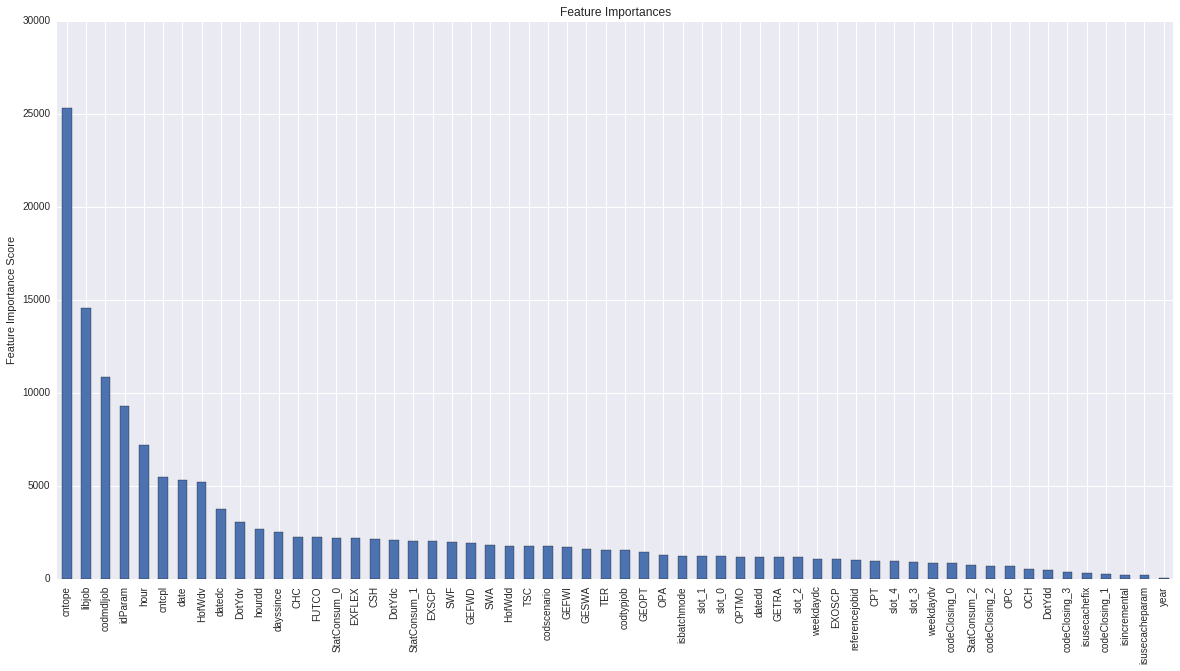

3242.935597896576


In [8]:
## Train Model
preds, train_preds, score, cvscores = modelfit(xgbreg, data.job_duration, trans_data, trans_test, useTrainCV=True)

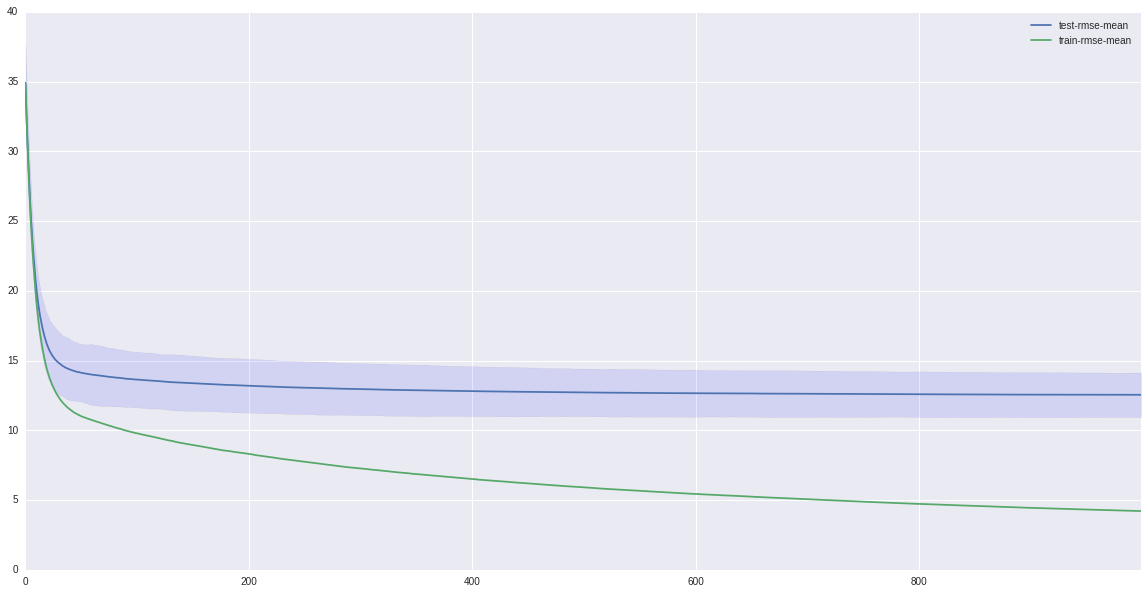

In [9]:
## Visualise cv-scores
# purely for intuition and can be removed
# alpha to scale up view of bias variance trade off
alpha = 4
df_cvscores = pd.DataFrame(cvscores)
ax = df_cvscores.ix[: ,['test-rmse-mean', 'train-rmse-mean']].plot()
df_cvscores['std_upper'] = df_cvscores.ix[:, 'test-rmse-mean'] + (alpha * df_cvscores.ix[:, 'test-rmse-std'])
df_cvscores['std_lower'] = df_cvscores.ix[: ,'test-rmse-mean'] - (alpha * df_cvscores.ix[:, 'test-rmse-std'])
ax.fill_between(df_cvscores.index, df_cvscores.std_upper, df_cvscores.std_lower, facecolor='blue', alpha=.1)
plt.show()

In [10]:
## Prediction on Test Data
pred = pd.DataFrame(xgbreg.predict(trans_test), columns=['job_duration'])

In [ ]:
## Run 
# predict for training set
train_pred = pd.DataFrame(xgbreg.predict(trans_data), index=trans_data.index, columns=['job_duration'])

# No negative times
# Use a mean of a job_duration subset to fill
pred.ix[pred.ix[:, 'job_duration'] < 0, 'job_duration'] = data.ix[train_pred.job_duration < 0, 'job_duration'].mean()

# Set name of model output
model_name = 'xgboost_final_submission'
# Set to dir of submission/output folder
submit = r'/Submissions/'
# Output test prediction to location
pred.to_csv(submit + model_name + '.csv', index=False)

## Oupt XGBFIR statistics spreadsheet
# this is the xgbfir package and is used to find feature importance
xgbfir.saveXgbFI(xgbreg, OutputXlsxFile=submit + model_name + '_FI.xlsx')

# Append CV Scores to XGBFIR
book = load_workbook(submit + model_name + '_FI.xlsx')
writer = pd.ExcelWriter(submit + model_name + '_FI.xlsx', engine='openpyxl') 
writer.book = book
writer.sheets = dict((ws.title, ws) for ws in book.worksheets)
cvscores.to_excel(writer, sheet_name='cvscore', index=False, engine='openpyxl')
writer.save()

# Dump XGBoost model to a pickle file
save_model_path = r'/home/josh/Documents/Python Scripts/Data Science Challenges/ENGIE DSC/IT Operations/Models/'
pickle.dump(xgbreg, open(save_model_path + model_name + '.dat', "wb"))

In [ ]:
# To load the XGBoost Pickled Model Run:
loaded_model = pickle.load(open(save_model_path +  model_name + '.dat', "rb"))